# Classification with Logistic Regression

In this notebook, classification is applied using multivarite logistic regression. The model was chosen for its advantages of interpretability and applicability for binary classification.

For the final project, there are a few key changes made from PDL2 Logistic Regression.

The linear assumptions of the logistic regression model were first assessed on the raw dataset. First, we will assess the correlation between the features with VIF and correlation matrix. This is tested in a different file titled, feature_engineering_multicollinearity. From the results, we created an interaction term called solar_exports which is used in the dataset for this file. The second linear assumption we will assess is the linearity of the log-odds (logit) to the contiunous variables, for which the code can be found in this file.

Next, the month data will be aggregated to create dummy variables for seasons. We believed that the this would have a stronger signal than month for predicting curtailment.

Then, similarly to the process of PDL2, we will tune hyperparameters of the logistic regression model using k-Fold CV. We will perform feature selection using the built-in lasso (l1 penalty) pentaly in sklearn's LogisticRegressionCV, thus we will not perform a stepwise subset feature selection as we did in PDL2. This is computationally faster and easier than a stepwise subset selection. Because we are applying lasso, it is important to apply standardization to our raw feature dataset before the analysis, so that the features are not penalize base on their magnitudes.

Finally, after the features have been selected on the basis o ffeature importance, we will fit StatsModel's logistic regression model to obtain the model summaray which includes information such as feature coefficients, p-values, and 95% confidence intervals.

In [ ]:
# Ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Import Packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import statsmodels.api as sm
import math
from scipy import stats

from imblearn.over_sampling import SMOTE
from IPython.display import Image, display

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.metrics import roc_curve, roc_auc_score

from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

In [ ]:
# Define classification metrics to assess model performance
def classification_metrics(matrix):
    TN = matrix[0][0]
    FN = matrix[1][0]
    FP = matrix[0][1]
    TP = matrix[1][1]
    N  = TN + FP
    P  = FN + TP
    P_star = FP + TP

    accuracy    = (TN + TP)/(N+P)
    specificity = TN/N
    sensitivity = TP/P
    precision   = TP/P_star

    return accuracy, specificity, sensitivity, precision

### First, the data is imported and the curtailment column is converted into a binary qualitative response: 0 = no curtailment, 1 = curtailment.

In [ ]:
# Import data and preview
df = pd.read_csv('final_data.csv')
df.head()

,Unnamed: 0,percent_wind_gen,percent_solar_gen,exports,total_load,total_lmp,battery_en,battery_soc,season_summer,season_spring,season_winter,solar_exports,total_curtailment
0,0,0.265874,0.0,-69960.360000,21302.162944,114.687870,41.976,6524.477167,0,0,1,-0.0,0.0
1,1,0.303146,0.0,-67462.573333,20803.750237,108.752210,-5.863,6460.896417,0,0,1,-0.0,0.0
2,2,0.327688,0.0,-65642.693333,20300.078086,102.776174,-54.224,6465.033667,0,0,1,-0.0,0.0
3,3,0.326433,0.0,-64974.106667,19914.921017,106.676475,19.609,6460.216500,0,0,1,-0.0,0.0
4,4,0.292937,0.0,-65427.986667,19975.842246,110.358796,8.992,6428.138083,0,0,1,-0.0,0.0


In [ ]:
# Create two curtailment classes
df['curtailment_class'] = (df['total_curtailment'] > 0).astype(int)

### Next, the data is split into its features and response variables. Month was not used as a variable as the season dummy variables were created from month. The class balance is analyzed.

In [ ]:
# All features except total curtailment, wind curtailment, and solar curtailment
X = df[['Unnamed: 0', 'percent_wind_gen', 'percent_solar_gen', 'exports', 'total_load', 'total_lmp', 'battery_en','battery_soc', 'season_summer', 'season_spring', 'season_winter', 'solar_exports']]
y = df[['Unnamed: 0', 'curtailment_class']]

In [ ]:
#Remove Nan values
X = X.dropna()

In [ ]:
df = X.merge(y)

X = df[['percent_wind_gen', 'percent_solar_gen', 'exports', 'total_load', 'total_lmp', 'battery_en','battery_soc', 'season_summer', 'season_spring', 'season_winter', 'solar_exports']]
y = df[['curtailment_class']]

In [ ]:
# Find class balance
num_curtailment = (df['curtailment_class'] == 1).sum()
num_no_curtailment = (df['curtailment_class'] == 0).sum()
print('Curtailment instances: ', num_curtailment)
print('Non-curtailment instances: ', num_no_curtailment)
print('Total: ', len(df))

if num_curtailment > num_no_curtailment:
    print('The majority class is curtailment.')
else:
    print('The majority class is no curtailment.')

Curtailment instances:  9298
Non-curtailment instances:  8246
Total:  17544
The majority class is curtailment.


## Multivariate Logistic Regression
An initial Multivariate Logisitic Regression was fitted using scikit-learn without adjusting hyperparameters of gamma. MLR was retained over SVM because of its higher interpretability espeically when using Statsmodel as it outputs coefficients, p-values, and CI associated with each feature, which would be a better model fit for the purpose and audience of our study. The model was scaled and regularized.

Perform Logistic Regression using Scikit-learn LogisticRegressionCV which allows for subset selection by tuning the 'penalty' parameter. This is computationally more efficient and requires less coding than if we were to perform stepwise subset selection and then to perform logistic regression using Statsmodels or Scikit-Learn. Moreover in scikit-learn, we can tune and set hyperparameters like Cs, cv, .


However, our project values inference, thus we will perform Statsmodel LogitModel after features have been selected by scikit-learns LogisticRegressionCV. The second allows to examine and access the statistical information of model.

## Logistic Regression - Linear Assumption Check

In this section, we'll assess two major assumptions of the logistic regression:

#1) Outliers and leverage points: we will calculate Cook's Distance which is a measure of a point's influence on the overall model fit to help us identify which data could potentially impact our results disproportionately. We will use the method here: https://github.com/kennethleungty/Logistic-Regression-Assumptions/blob/main/Logistic_Regression_Assumptions.ipynb

#2) Linearity of logit with respect to continuous predictors. We will plot the logit against each predictor and overlay LOWESS to identify nonlinear trends that could be improved with transformations.

We will use our raw dataset to check these assumptions.

In [ ]:
# Use GLM method so we can retrieve influence
X_outliers = X.copy()
X_outliers = sm.add_constant(X, prepend=False)
y_outliers = y.copy()


logit = GLM(y_outliers, X_outliers, family=families.Binomial())
logit_results = logit.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      curtailment_class   No. Observations:                17544
Model:                            GLM   Df Residuals:                    17532
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9590.2
Date:                Thu, 18 Dec 2025   Deviance:                       19180.
Time:                        20:21:30   Pearson chi2:                 1.80e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2513
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
percent_wind_gen      4.5545      0.28

In [ ]:
# Retrieve influence measures from the model
influence = logit_results.get_influence()
summary_df = influence.summary_frame()
summary_df = summary_df.loc[:, ['cooks_d']]

summary_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
summary_df['std_resid'] = summary_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort indices by Cook's Distance
summary_df.sort_values('cooks_d', ascending=False, inplace=True)
summary_df

,cooks_d,std_resid
13673,1.327935e-02,16.301665
13674,7.714786e-03,1.183169
5418,5.826359e-03,1.574905
15497,4.562517e-03,19.675624
4939,4.189109e-03,1.465423
...,...,...
13002,9.293459e-09,0.050443
13507,7.612147e-09,0.047484
13961,6.849473e-09,0.045664
13506,6.830436e-09,0.044922


The threshold for Cook's Distance is: 0.0002


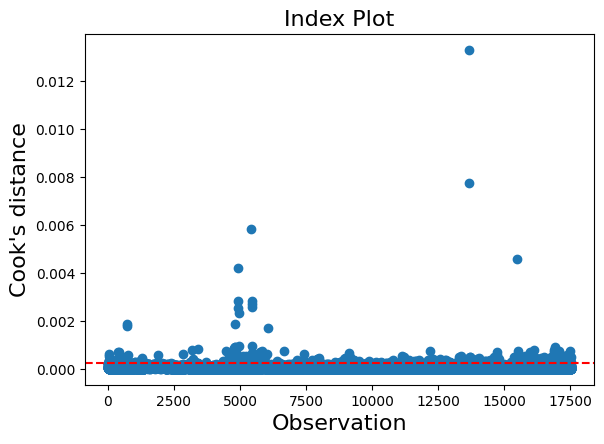

In [ ]:
# Set threshold of 4 / N where N is the # of observations
cook_threshold = 4 / len(X)
print(f'The threshold for Cook\'s Distance is: {round(cook_threshold,4)}')

# Plot Cook's Distance influence plot to visualize
fig = influence.plot_index(y_var='cooks', threshold=cook_threshold)

for ax in fig.axes:
    for text in ax.texts:
        text.set_visible(False)

plt.axhline(y=cook_threshold, ls='--', color='red')
fig.tight_layout(pad=2)
plt.show()

In [ ]:
# Calculate the total proportion of influential points and outliers
if_points = summary_df[summary_df['cooks_d'] > cook_threshold]
prop_if = round(100*(len(if_points) / len(X)), 1)
print(f'{prop_if}% of observations are influential')

outliers = summary_df[(summary_df['cooks_d'] > cook_threshold) & (summary_df['std_resid'] > 3)] # Standard deviation > 3 defined as outlier here
prop_outliers = round(100*(len(outliers) / len(X)),1)
print(f'{prop_outliers}% of observations are influential outliers')

3.2% of observations are influential
0.5% of observations are influential outliers


### There is a low percentage of outliers and influential points. While these points may affect the results of our model, we will not remove them for now because they make up a very small fraction of the total dataset and we have no reason to believe they aren't real (i.e., equipment error).

### Next, we will check the assumption that the logit is linear with respect to our continuous variables. We will not yet standardize or do any other pre-processing because some of the diagnostics for this test require only positive values.

In [ ]:
# Split the data into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# Perform a logistic regression using Statsmodel
X_train_const = sm.add_constant(X_train)
logreg = sm.Logit(y_train, X_train_const).fit()

# Using the Logit-function, predict log-odds probabilities
y_pred_prob = logreg.predict(X_train_const)

# Using log-odds probabilities, find logit values
logit_values = np.log(y_pred_prob / (1 - y_pred_prob))

Optimization terminated successfully.
         Current function value: 0.546467
         Iterations 6


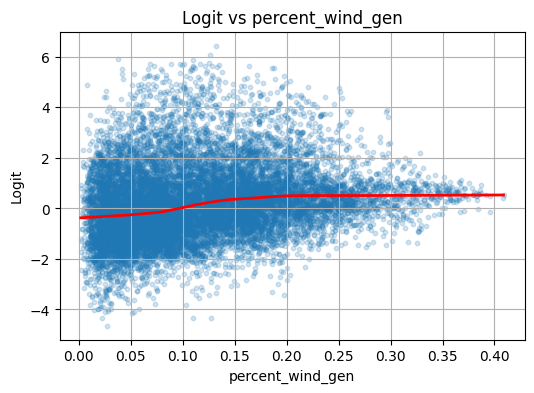

/opt/miniforge/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


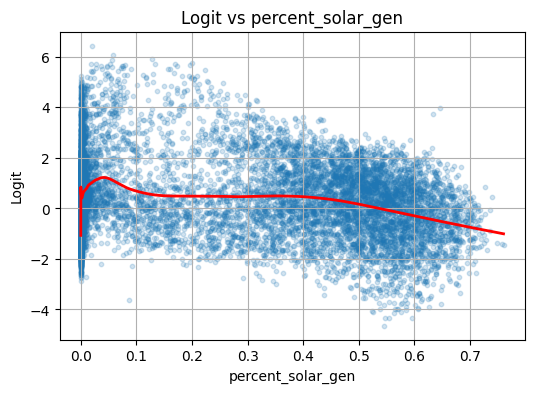

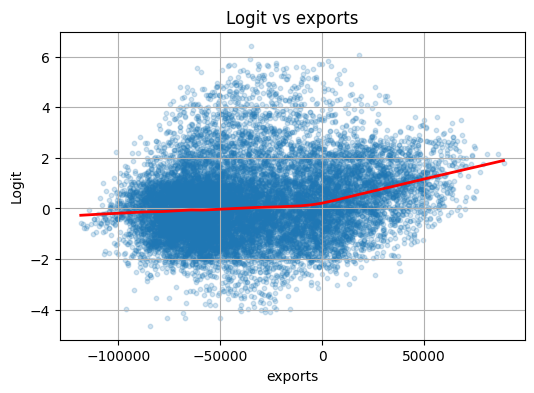

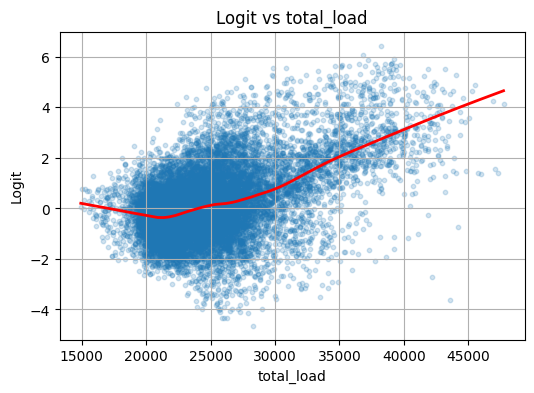

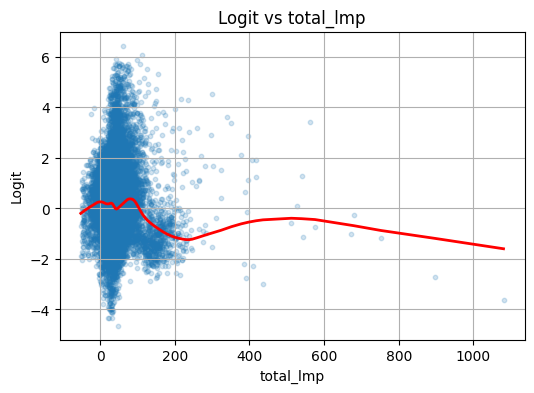

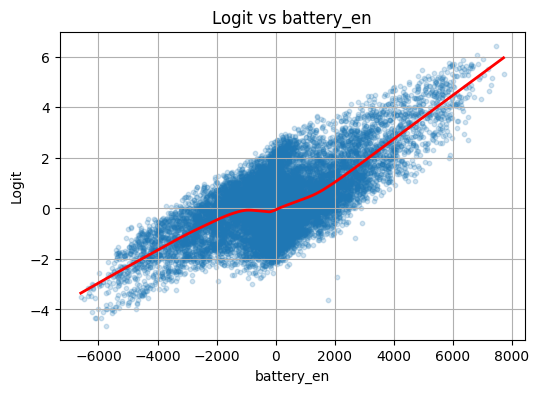

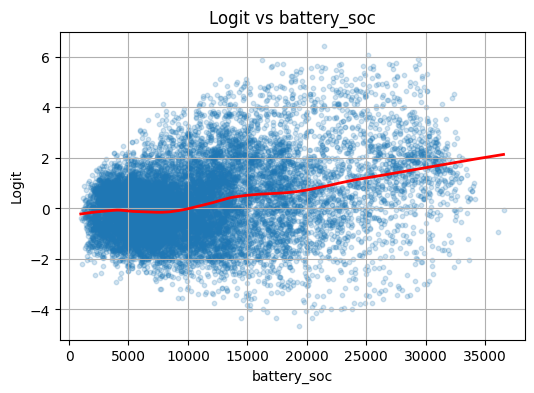

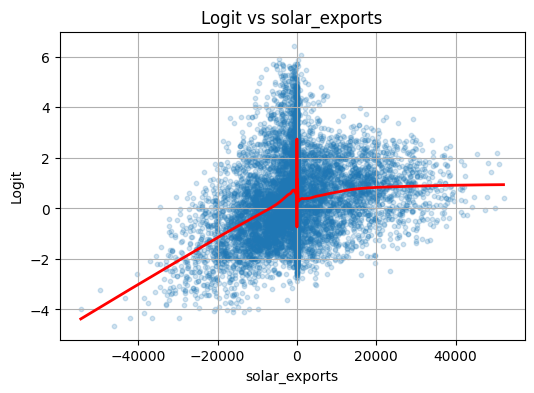

In [ ]:
# We can now filter for our continuous variables and look at the linearity of the logit with respect to each
non_cont_var = ['season_summer', 'season_spring', 'season_winter', 'const']
cont_var = [col for col in X.columns if col not in non_cont_var]

# Plot LOWESS line within scatterplot to assess linearity using span of 30% (arbitrary, but not overly smoothed)
for col in cont_var:
    if X_train_const[col].nunique() > 2:
        plot_X = X_train_const[col].values
        plot_y = logit_values

        plt.figure(figsize=(6, 4))
        plt.scatter(plot_X, plot_y, alpha=0.2, s=10)
        smoothed = lowess(plot_y, plot_X, frac=0.3)  # frac controls the smoothing window
        plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOWESS')

        plt.xlabel(col)
        plt.ylabel("Logit")
        plt.title(f"Logit vs {col}")
        plt.grid(True)
        plt.show()

### Looking at the logit plots, there is some nonlinearity. However, for the interpretability of our model, we want to minimize complexity. For this reason, we will only address non-linearity for total load and total LMP.

In [ ]:
# To address nonlinearity, we will add a polynomial term to total_load and a square-root term in total LMP
X['total_load_square'] = X['total_load'] ** 2
X['total_lmp_sqrt'] = np.sign(X['total_lmp']) * np.sqrt(np.abs(X['total_lmp']))

/tmp/ipykernel_1820482/765691314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['total_load_square'] = X['total_load'] ** 2


In [ ]:
# Re-split the data into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# Perform a logistic regression using Statsmodel
X_train_const = sm.add_constant(X_train)
logreg = sm.Logit(y_train, X_train_const).fit()

# Using the Logit-function, predict log-odds probabilities
y_pred_prob = logreg.predict(X_train_const)

# Using log-odds probabilities, find logit values
logit_values = np.log(y_pred_prob / (1 - y_pred_prob))

Optimization terminated successfully.
         Current function value: 0.545281
         Iterations 6


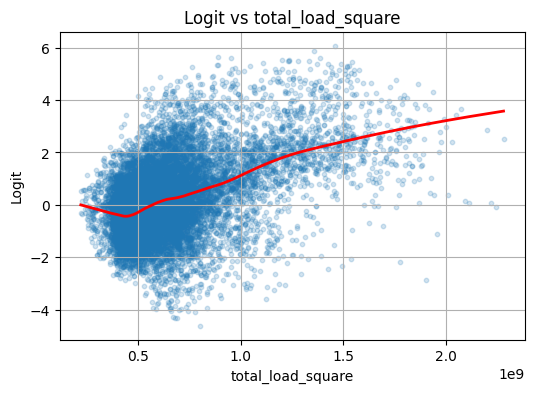

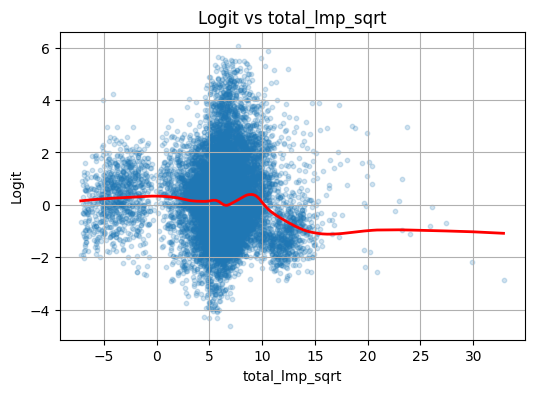

In [ ]:
# Plot LOWESS line within scatterplot to assess linearity using span of 30% (arbitrary, but not overly smoothed)
for col in ['total_load_square', 'total_lmp_sqrt']:
    if X_train_const[col].nunique() > 2:
        plot_X = X_train_const[col].values
        plot_y = logit_values

        plt.figure(figsize=(6, 4))
        plt.scatter(plot_X, plot_y, alpha=0.2, s=10)
        smoothed = lowess(plot_y, plot_X, frac=0.3)  # frac controls the smoothing window
        plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOWESS')

        plt.xlabel(col)
        plt.ylabel("Logit")
        plt.title(f"Logit vs {col}")
        plt.grid(True)
        plt.show()

## Logistic Regression - Feature Selection using Regularization
Perform a logistic regression w/ sklearn LogisticRegressionCV by adjusting its hyperparameters.

In [ ]:
X = X[['percent_wind_gen', 'percent_solar_gen', 'exports', 'total_load_square', 'total_lmp_sqrt', 'battery_en','battery_soc', 'season_summer', 'season_spring', 'season_winter', 'solar_exports']]

In [ ]:
# Standardize the predictive variables (features)
X_std = StandardScaler().fit_transform(X)
X_std = pd.DataFrame(data = X_std, columns = X.columns)

In [ ]:
# Add a constant for statsmodel
X_std = sm.add_constant(X_std, has_constant='add')

In [ ]:
# Resplit the data into test and train datasets
X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size = 0.2, random_state = 0)

In [ ]:
# Balance classes (already relatively balanced) using SMOTE
balance = SMOTE(random_state = 0)
balanced_X_train_std, balanced_y_train = balance.fit_resample(X_train_std, y_train)

LogisticRegressionCV does not provide statistical summaries. In order to determine which features were eliminated and which were retained, look at the coefficients of the features. If a feature has a coefficient of 0, then it was eliminated under the l2 pentaly. If the coefficient is not 0, the feature was retained.

In [ ]:
balanced_y_train = np.ravel(balanced_y_train)

logreg = LogisticRegressionCV(
    Cs = np.logspace(-6, -1, 50),
    cv=10,
    penalty='l1', # l1 = lasso regularization for subset selection
    solver='liblinear',
    random_state=0)

logreg.fit(balanced_X_train_std, balanced_y_train)

# For binary classification, just take the scalar
best_C = logreg.C_[0]
print("Optimized C:", best_C)

Optimized C: 0.024420530945486497


In [ ]:
# Coefficients from the trained logistic regression
coefs = logreg.coef_.ravel()
features = X_test_std.columns

coef_df = pd.DataFrame({
    'Feature' : features,
    'Coefficients' : coefs,
    'Retained': coefs !=0
})

print(coef_df.sort_values('Retained'))

              Feature  Coefficients  Retained
11      solar_exports      0.000000     False
0               const      0.052221      True
1    percent_wind_gen      0.293571      True
2   percent_solar_gen      0.299890      True
3             exports      0.376602      True
4   total_load_square      0.365389      True
5      total_lmp_sqrt     -0.235828      True
6          battery_en      1.250452      True
7         battery_soc     -0.089722      True
8       season_summer      0.226512      True
9       season_spring      0.020871      True
10      season_winter     -0.264197      True


### Solar_exports is not an important feature in predicting curtailment, thus eliminate from the model. Next perform logistic regession with the new subset of features, this time with Statsmodel, in order to obtain feature coefficients, p-values, and 95% confidence intervals.

# Logistic Regression w/ Statsmodel

In [ ]:
X_new = X[['percent_wind_gen', 'percent_solar_gen', 'exports', 'total_load_square', 'total_lmp_sqrt', 'battery_en','battery_soc', 'season_summer', 'season_spring', 'season_winter']]

In [ ]:
# Standardize the predictive variables (features)
X_std = StandardScaler().fit_transform(X_new)
X_std = pd.DataFrame(data = X_std, columns = X_new.columns)

In [ ]:
# Add a constant for statsmodel
X_std = sm.add_constant(X_std, has_constant='add')

In [ ]:
# Resplit the data into test and train datasets
X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size = 0.2, random_state = 0)

In [ ]:
# Balance classes (already relatively balanced) using SMOTE
balance = SMOTE(random_state = 0)
balanced_X_train_std, balanced_y_train = balance.fit_resample(X_train_std, y_train)

In [ ]:
# Perform a logistic regression w/ Statsmodels Logit-function
logit_model = sm.Logit(balanced_y_train, balanced_X_train_std).fit()

Optimization terminated successfully.
         Current function value: 0.550511
         Iterations 6


In [ ]:
# Model Summary with coefficients, p-value, and CI
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      curtailment_class   No. Observations:                14920
Model:                          Logit   Df Residuals:                    14909
Method:                           MLE   Df Model:                           10
Date:                Thu, 18 Dec 2025   Pseudo R-squ.:                  0.2058
Time:                        20:22:03   Log-Likelihood:                -8213.6
converged:                       True   LL-Null:                       -10342.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1026      0.020      5.245      0.000       0.064       0.141
percent_wind_gen      0.3258      0.023     14.330      0.000       0.281       0.370
percent_solar_gen     0.4013      0.049      8.182      0.000       0.305       0.497
exports               0.3753      0.033     11.498      0.000       0.311       0.439
total_load_square     0.4269      0.034     12.405      0.000       0.359       0.494
total_lmp_sqrt       -0.2686      0.030     -9.003      0.000      -0.327      -0.210
battery_en            1.3635      0.038     35.448      0.000       1.288       1.439
battery_soc          -0.1700      0.029     -5.935      0.000      -0.226      -0.114
season_summer         0.2329      0.026      8.882      0.000       0.182       0.284
season_spring         0.0165      0.026      0.648      0.517      -0.033       0.067
season_winter        -0.2561      0.024    -10.463      0.000      -0.304      -0.208
=====================================================================================
"""

### All except season_spring is found to be statistically significant. Thus remove feature and run the model again.

In [ ]:
X_new = X[['percent_wind_gen', 'percent_solar_gen', 'exports', 'total_load_square', 'total_lmp_sqrt', 'battery_en','battery_soc', 'season_summer', 'season_winter']]

In [ ]:
# Standardize the predictive variables (features)
X_std = StandardScaler().fit_transform(X_new)
X_std = pd.DataFrame(data = X_std, columns = X_new.columns)

In [ ]:
# Add a constant for statsmodel
X_std = sm.add_constant(X_std, has_constant='add')

In [ ]:
# Resplit the data into test and train datasets
X_train_std, X_test_std, y_train, y_test = train_test_split(X_std, y, test_size = 0.2, random_state = 0)

In [ ]:
# Balance classes (already relatively balanced) using SMOTE
balance = SMOTE(random_state = 0)
balanced_X_train_std, balanced_y_train = balance.fit_resample(X_train_std, y_train)

In [ ]:
# Perform a logistic regression w/ Statsmodels Logit-function
logit_model = sm.Logit(balanced_y_train, balanced_X_train_std).fit()

Optimization terminated successfully.
         Current function value: 0.550177
         Iterations 6


In [ ]:
# Model summary with coefficients, p-value, and CI
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      curtailment_class   No. Observations:                14920
Model:                          Logit   Df Residuals:                    14910
Method:                           MLE   Df Model:                            9
Date:                Thu, 18 Dec 2025   Pseudo R-squ.:                  0.2063
Time:                        20:22:03   Log-Likelihood:                -8208.6
converged:                       True   LL-Null:                       -10342.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1036      0.020      5.292      0.000       0.065       0.142
percent_wind_gen      0.3296      0.022     14.881      0.000       0.286       0.373
percent_solar_gen     0.4075      0.049      8.354      0.000       0.312       0.503
exports               0.3781      0.032     11.658      0.000       0.315       0.442
total_load_square     0.4267      0.034     12.419      0.000       0.359       0.494
total_lmp_sqrt       -0.2727      0.030     -9.241      0.000      -0.331      -0.215
battery_en            1.3737      0.038     36.384      0.000       1.300       1.448
battery_soc          -0.1771      0.028     -6.380      0.000      -0.231      -0.123
season_summer         0.2255      0.024      9.512      0.000       0.179       0.272
season_winter        -0.2632      0.022    -12.016      0.000      -0.306      -0.220
=====================================================================================
"""

In [ ]:
# Coefficients
coef = logit_model.params
ci = logit_model.conf_int()
ci.columns = ["ci_lower", "ci_upper"]

coef_summary = pd.DataFrame({
    "feature": coef.index,
    "coefficient": coef.values,
    "ci_lower": ci["ci_lower"].values,
    "ci_upper": ci["ci_upper"].values
})

coef_summary = coef_summary[coef_summary['feature'] != 'const'] # Remove constant

# Sort coefficients by magnitude
coef_summary = coef_summary.reindex(
    coef_summary['coefficient'].abs().sort_values(ascending=False).index
)

# Reset index for clean printing
coef_summary = coef_summary.reset_index(drop=True)
print(coef_summary)

             feature  coefficient  ci_lower  ci_upper
0         battery_en     1.373743  1.299741  1.447745
1  total_load_square     0.426671  0.359336  0.494005
2  percent_solar_gen     0.407478  0.311876  0.503080
3            exports     0.378105  0.314538  0.441671
4   percent_wind_gen     0.329622  0.286207  0.373036
5     total_lmp_sqrt    -0.272744 -0.330590 -0.214899
6      season_winter    -0.263198 -0.306130 -0.220266
7      season_summer     0.225495  0.179031  0.271959
8        battery_soc    -0.177081 -0.231481 -0.122682


In [ ]:
new_feature_names = [
    'Change in Battery Charge',
    'Total Load',
    '% Solar Generation',
    'Exports',
    '% Wind Generation',
    'Total Locational Marginal Price',
    'Season Winter',
    'Season Summer',
    'Battery State of Charge',
]

# Assign new feature names
coef_summary['feature'] = new_feature_names

Finally, we can visualize our coefficients and associated uncertainty. We will categorize them into temporal, storage/exports, load/generation, and price.

In [ ]:
# Create dictionary to color label features based on category
categories = {'% Wind Generation': 'Generation and Load',
    '% Solar Generation': 'Generation and Load',
    'Total Load': 'Generation and Load',
    'Change in Battery Charge': 'Storage and Exports',
    'Exports': 'Storage and Exports',
    'Total Locational Marginal Price': 'Price',
    'Season Summer': 'Temporal',
    'Season Winter': 'Temporal',
    'Battery State of Charge': 'Storage and Exports'
}

category_colors = {'Generation and Load': 'orange',
    'Price': 'green',
    'Storage and Exports': 'blue',
    'Temporal': 'red'
}

# Assign a color for each feature based on its category
coef_summary['category'] = coef_summary['feature'].map(categories)
coef_summary['color_plot'] = coef_summary['category'].map(category_colors).fillna('black')

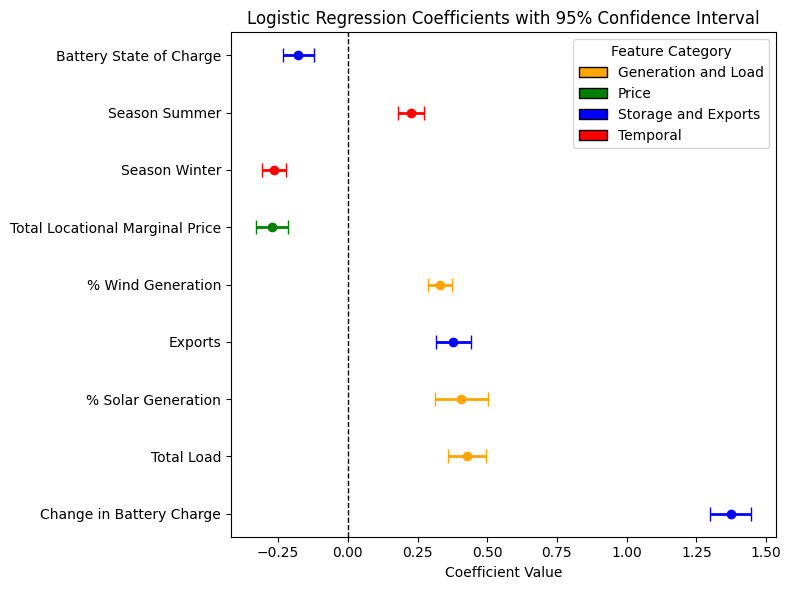

In [ ]:
# Compute error bars
low_error = coef_summary['coefficient'].values - coef_summary['ci_lower'].values
high_error = coef_summary['ci_upper'].values - coef_summary['coefficient'].values

plt.figure(figsize=(8, 6))
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

for idx, (i, row) in enumerate(coef_summary.iterrows()):
    plt.errorbar(
        x=row['coefficient'],
        y=idx,
        xerr=[[low_error[idx]], [high_error[idx]]],
        fmt='o',
        capsize=5,
        color=row['color_plot'],
        ecolor=row['color_plot'],
        elinewidth=2
    )

plt.yticks(range(len(coef_summary)), coef_summary['feature'])
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients with 95% Confidence Interval')

# Legend
legend_layout = [Patch(facecolor=color, edgecolor='black', label=category)
                 for category, color in category_colors.items()]
plt.legend(handles=legend_layout, title='Feature Category', loc='upper right')

plt.tight_layout()
plt.show()

## AUROC curve to evaluate discrimination performance

In [ ]:
# Using the Logit-function, predict log-odds probabilities
y_pred_prob = logit_model.predict(X_test_std)

# Using a 0.5 threshold, convert log-odds probabilities to binary predictions for test each observations
y_pred = (y_pred_prob >= 0.5).astype(int)

# Create a confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print('The confusion matrix is:')
print(cnf_matrix)

# Report on performance metrics
[accuracy_Logit, specificity_Logit, sensitivity_Logit, precision_Logit] = classification_metrics(cnf_matrix)
print('Accuracy:    %.3f' %accuracy_Logit)
print('Specificity: %.3f' %specificity_Logit)
print('Sensitivity: %.3f' %sensitivity_Logit)
print('Precision:   %.3f' %precision_Logit)

The confusion matrix is:
[[1243  428]
 [ 575 1263]]
Accuracy:    0.714
Specificity: 0.744
Sensitivity: 0.687
Precision:   0.747


In [ ]:
# ROC curve coordinates
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# AUROC value
auc_value = roc_auc_score(y_test, y_pred_prob)

print(f"AUROC: {auc_value:.3f}")

AUROC: 0.791


In [ ]:
# Scikit-learn uses a default threshold value of 0.5
fpr_50 = 1- specificity_Logit
tpr_50 = sensitivity_Logit

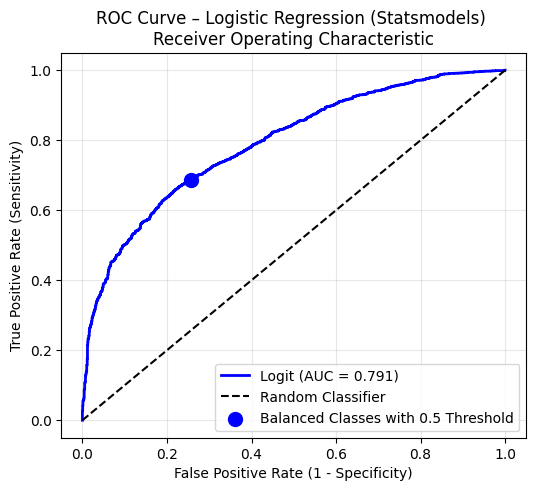

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Logit (AUC = {auc_value:.3f})', linewidth=2, c='b')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.scatter(fpr_50, tpr_50, s=100, marker='o', c='b', label = 'Balanced Classes with 0.5 Threshold')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve – Logistic Regression (Statsmodels) \nReceiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.show()